# Clustering performance evaluation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

matrix_functions.py contains all functions utilized for plotting and creating matrices for comparison of initial and proposed clusters to the ground truth clusters.

In [2]:
from matrix_functions import make_matrix, plot_matrix
from matrix_functions import group_similiar_clusters, get_clusters_ground_truth, remapping, evaluate_clustering
from matrix_functions import purity_index

## Re-mapping of the calculated clustering labels to labels used in the ground-truth column

Each cluster should be mapped to one or more ground-truth clusters depending on the number of cells they share.

In [3]:
df = pd.read_csv('test_clustering.csv')
labels_list = df.annotation.unique().tolist()

### make_matrix function
This function takes dataframe as input and produces a different type of matrices based on **comparison_type** parameter.
There are two comparison types, and the default one is set to "*clusters*".
- "*clusters*" is used when calculating the percentage of ground truth labels within initial or proposed clusters.
- "*dataframe*" is used when calculating the percentage of the total number of each ground truth label within the initial or proposed cluster. In other words, it calculates what share of the total number of instances of each label in dataframe is in each cluster.
- "*cosine*" is used when calculating cosine similarity between ground truth labels corresponding to each cluster.
     
Another parameter that can be defined is **column**, and the default value is "*cluster*". It defines which dataframe column will be used for getting the data. 
When new clusters are proposed, **column** should be the name of the column that contains data on the new proposed clustering.

In [4]:
matrix_clusters = make_matrix(df, comparison_type="clusters")
matrix_dataframe = make_matrix(df, comparison_type="dataframe")

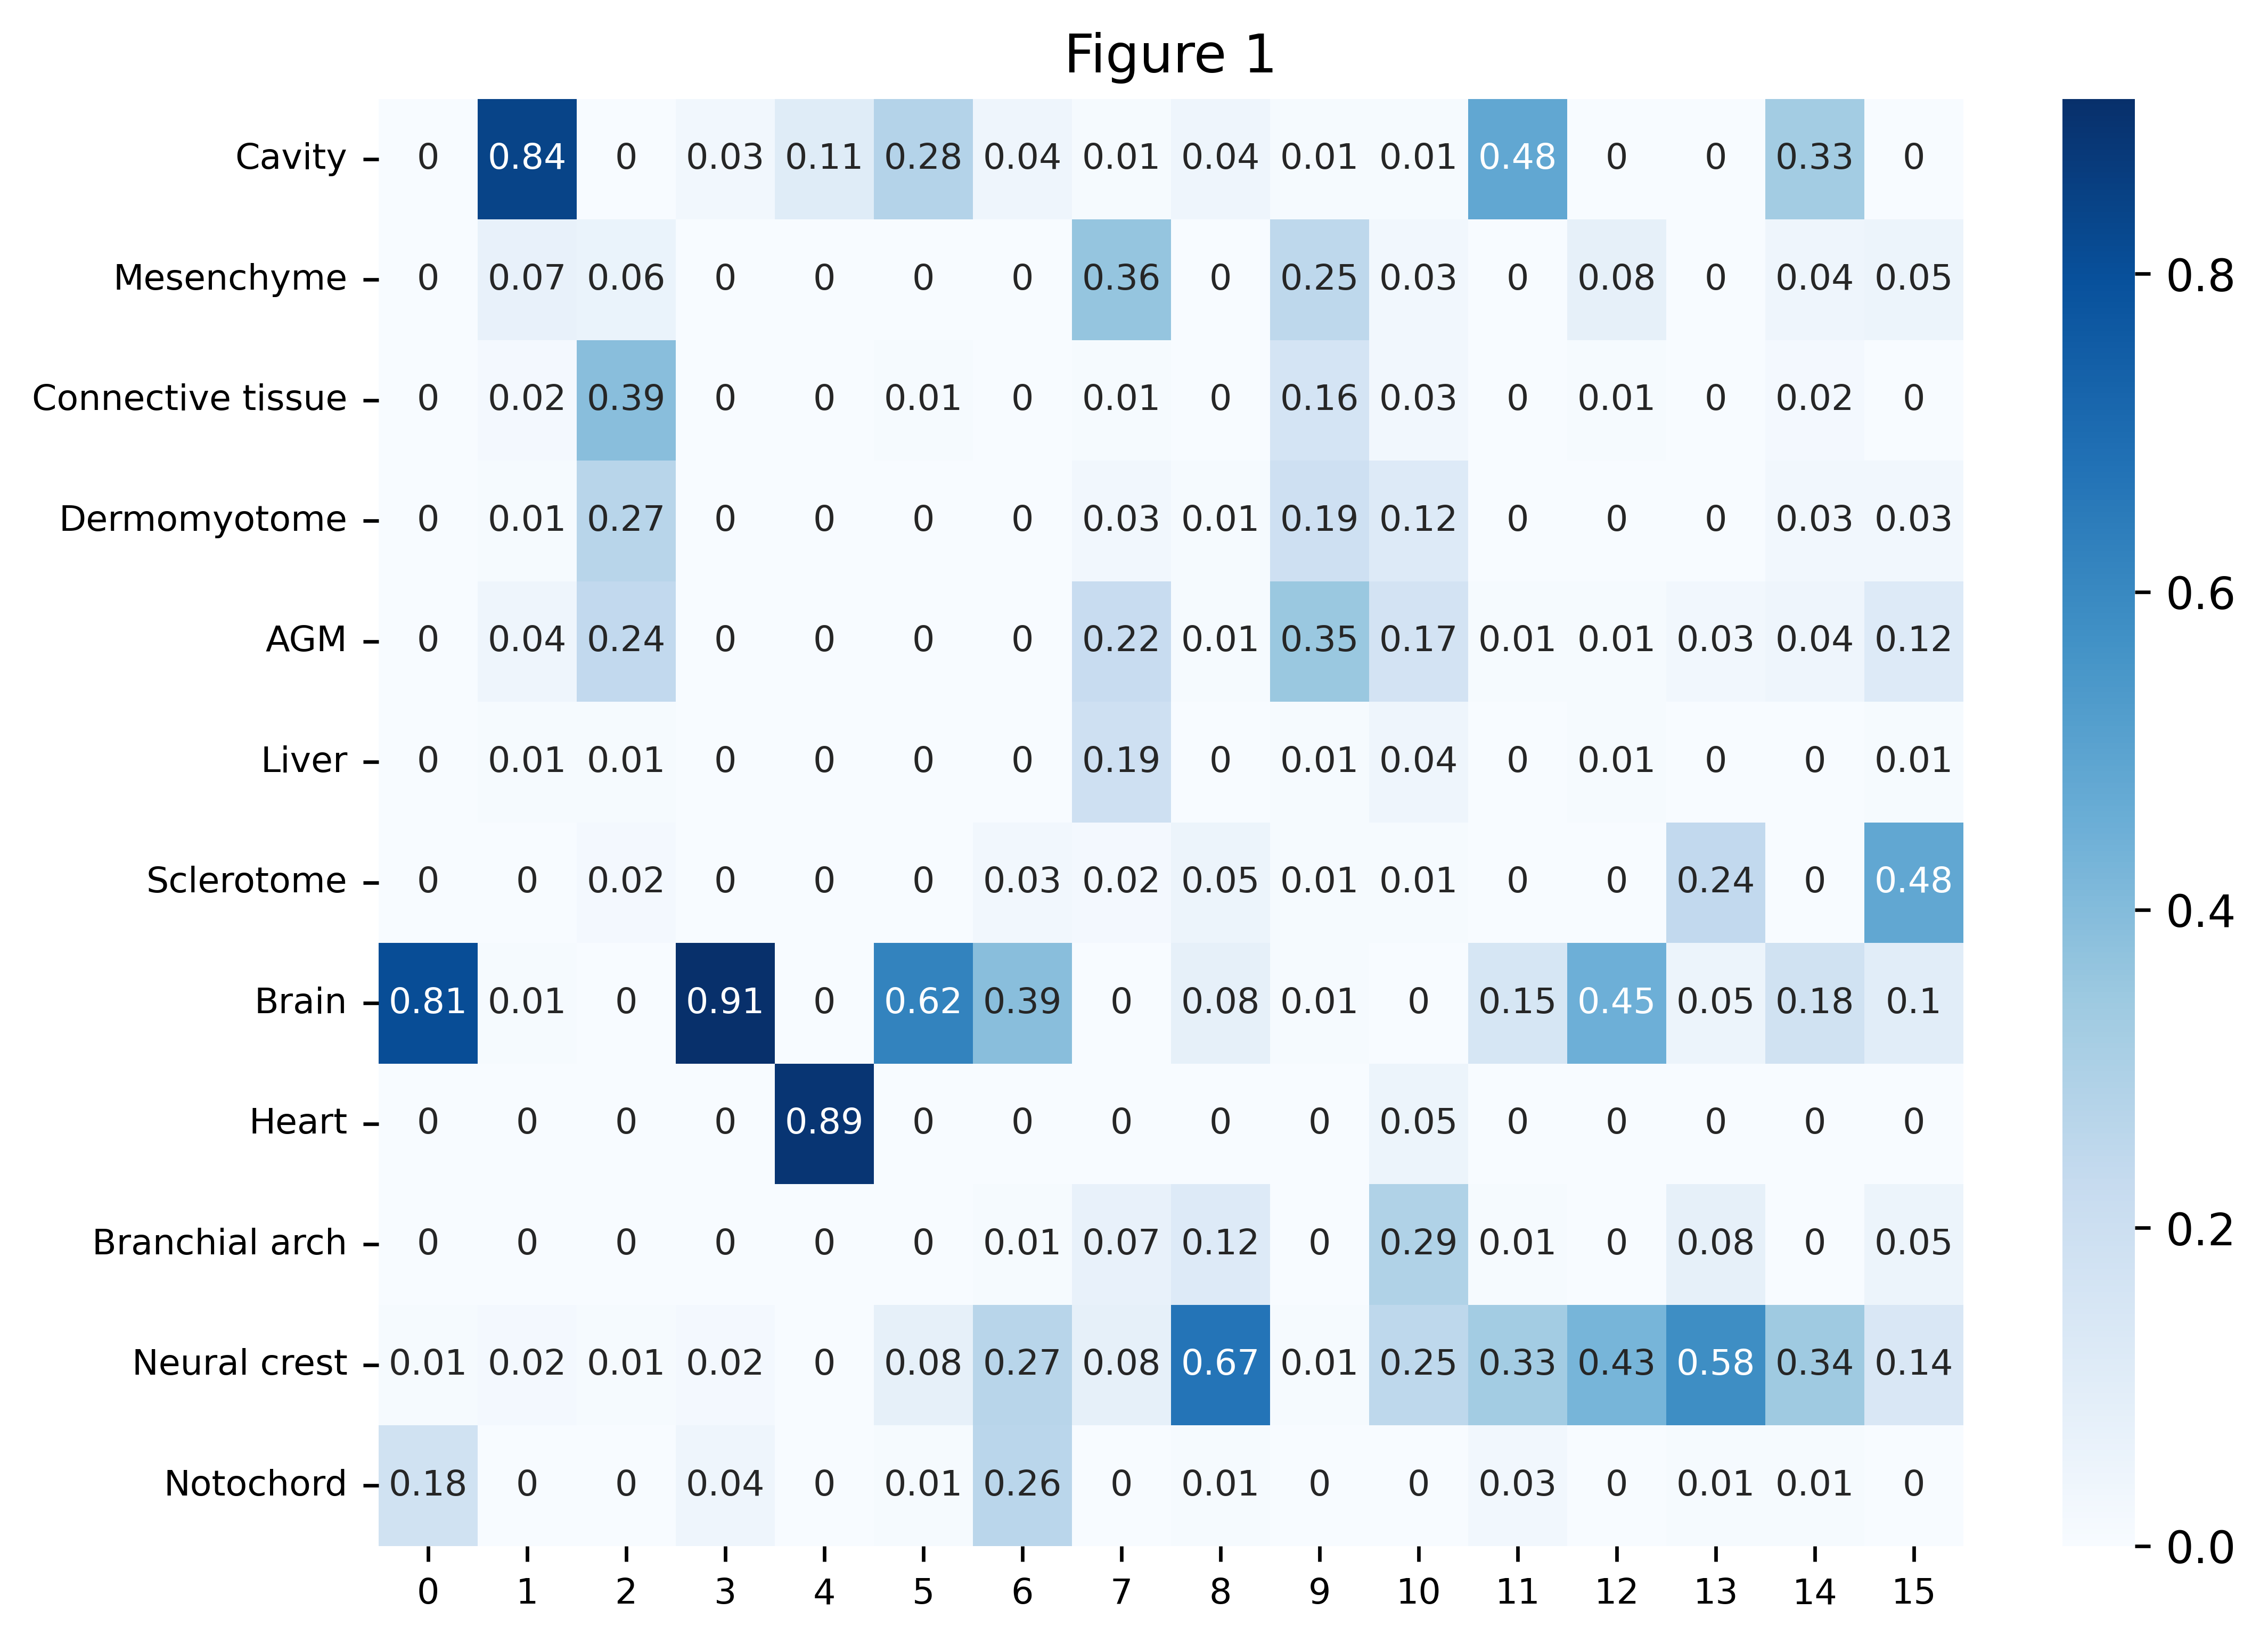

In [5]:
plot_matrix(matrix_clusters, labels_list, fig_size=(8,6), label_size=8, title="Figure 1")

For plotting is utilized custom-made plot_matrix function.
<br>
Values in **Figure 1** represent what percentage of ground truth labels within clusters, marked from 0 to 15 on the *x* axis, belong to ground truth labels seen on the *y* axis.
<br>
As can be seen, clusters 0 and 3 are very similar in regard that both clusters have a high percentage of labels *Brain*, and clusters 1 and 4 could be mapped to the *Cavity* and *Heart* labels, respectively. As for the other clusters, it is not clear to which labels they should be mapped, but there are some similar clusters e.g. clusters 11 and 14 have very similar percentages of labels *Neural crest*, *Brain*, and *Cavity*.

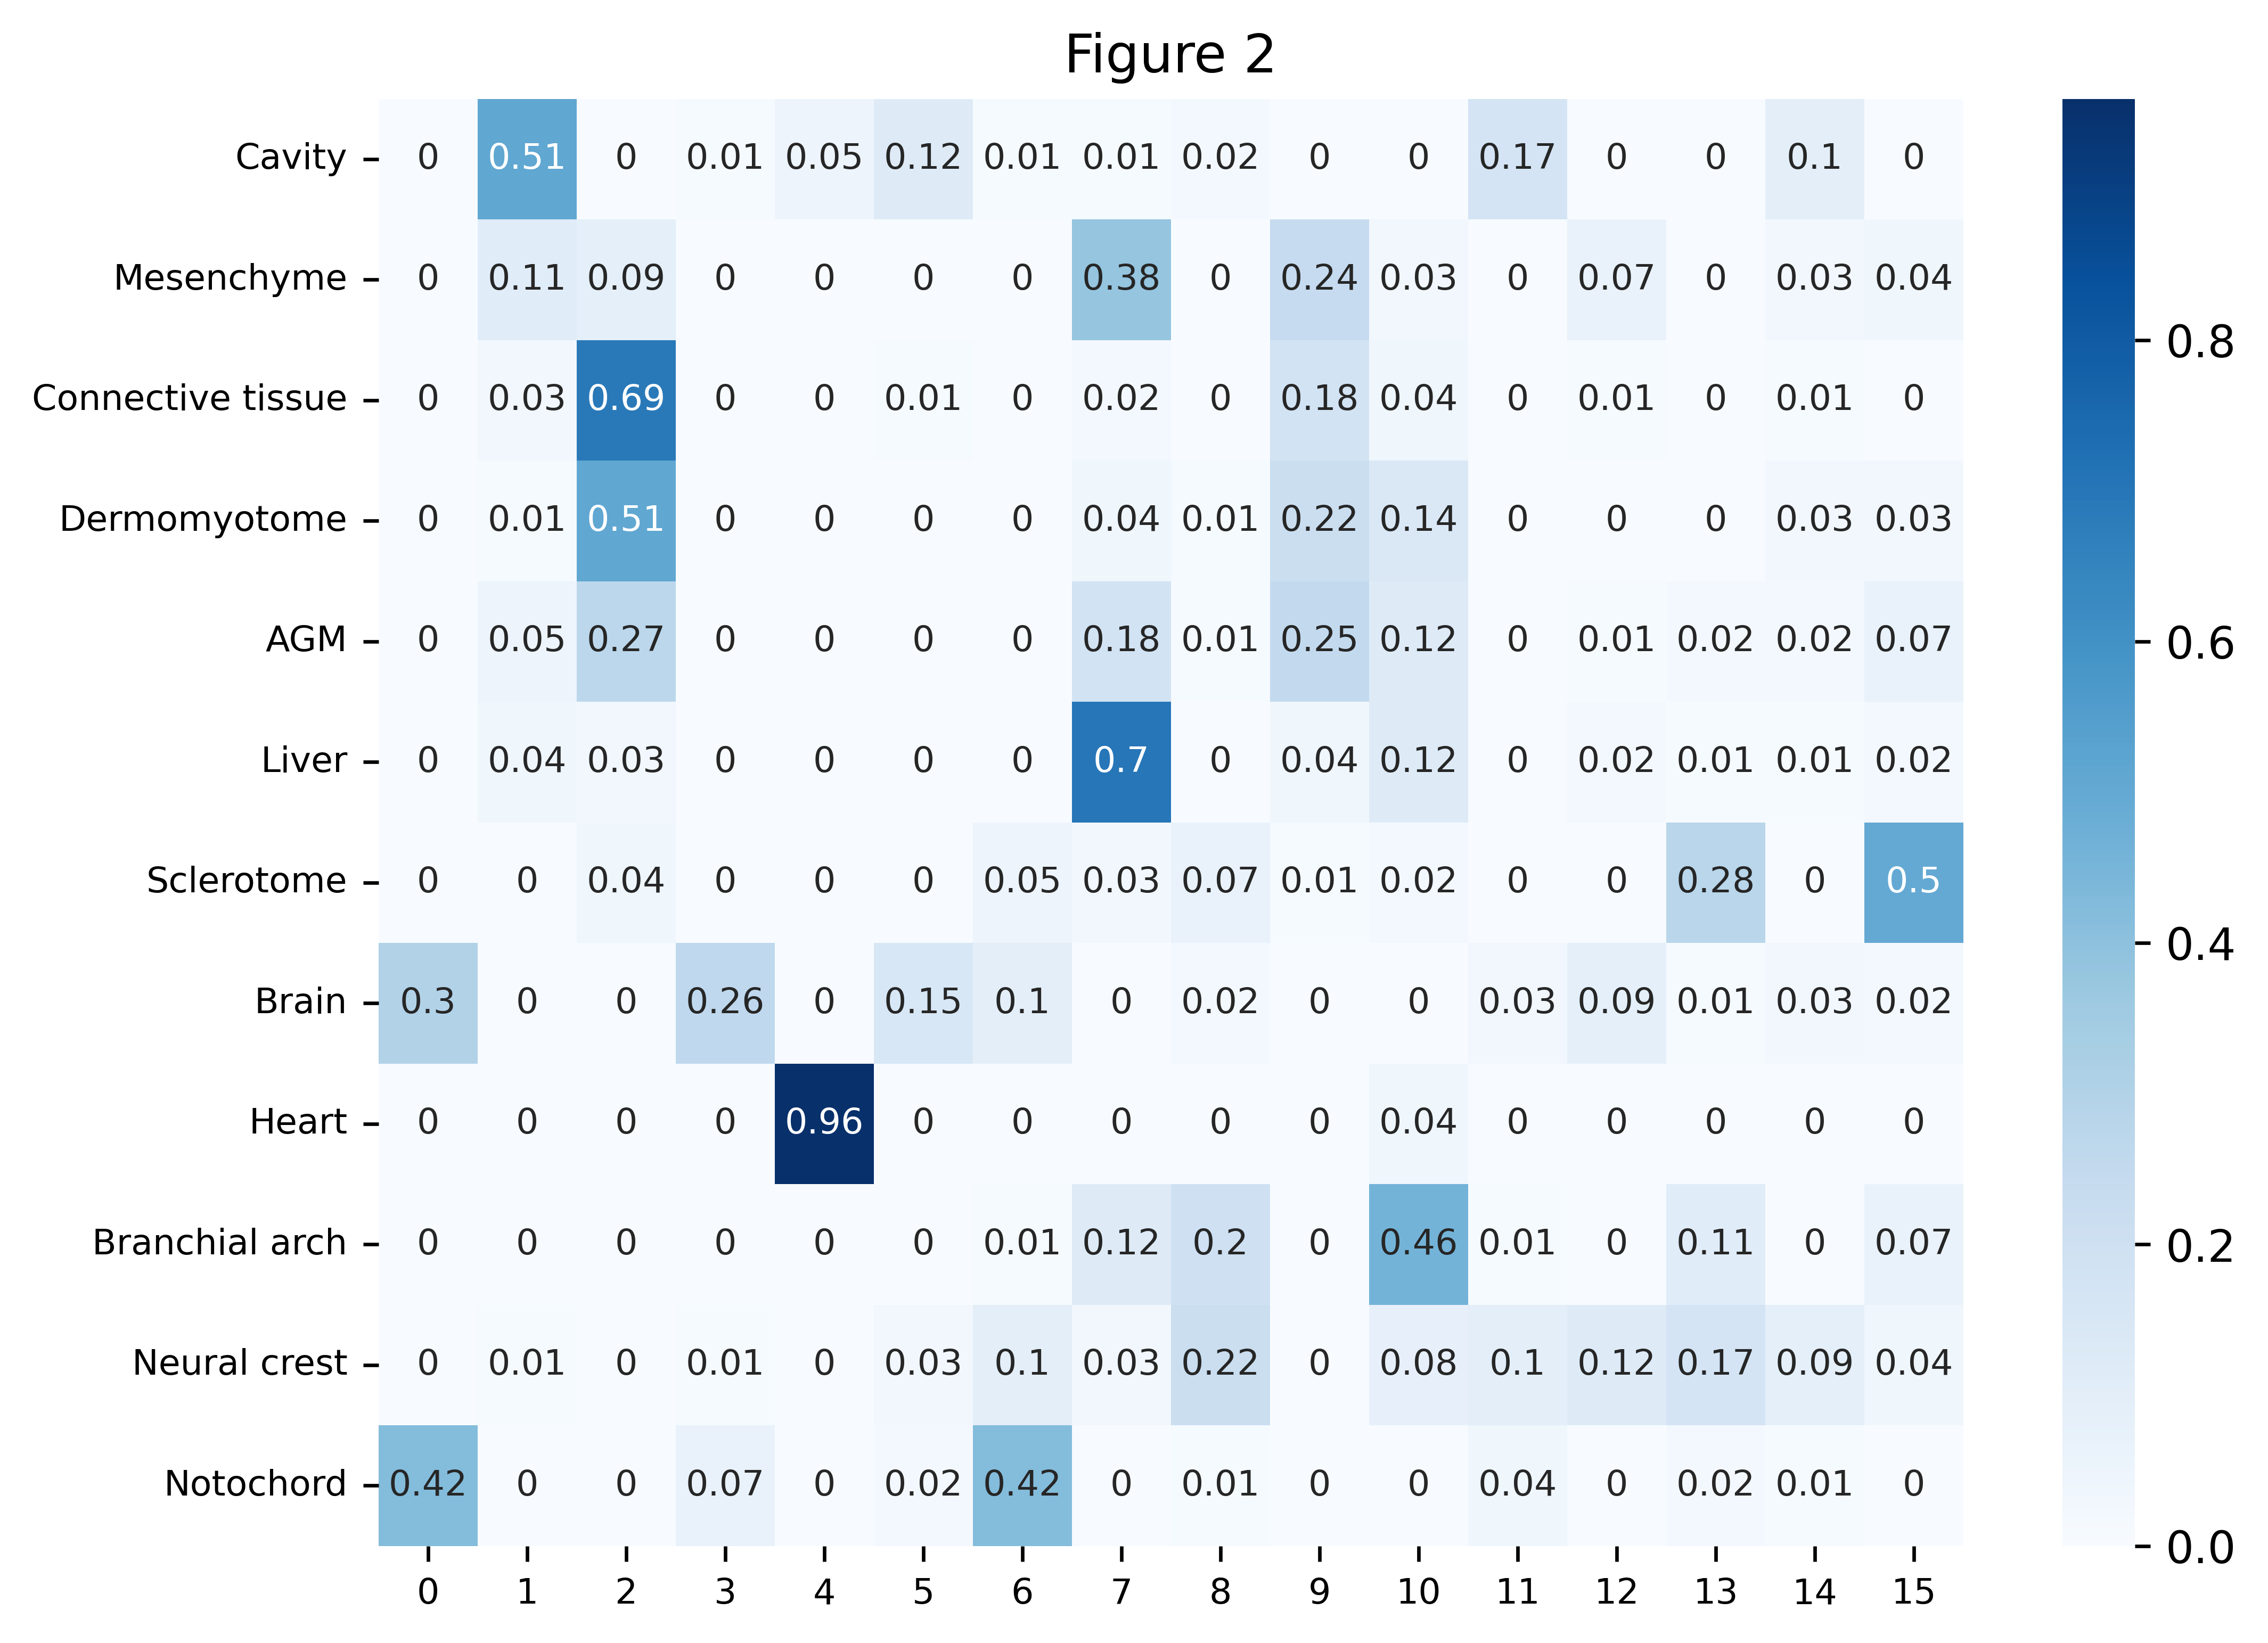

In [6]:
plot_matrix(matrix_dataframe, labels_list, fig_size=(8,6), label_size=8, title="Figure 2")

Values in **Figure 2** represent what percentage of the total number of each ground truth labels are contained within each initial cluster.
Example:
There are 1518 ground truth labels *Brain*, and in initial cluster 0, there are 449 occurrences of this label. So, the formula to calculate the percentage of the total number of instances of each label in dataframe within each cluster is:
$$ \frac{\text{number of occurences in cluster}}{\text{total number of occurences in dataframe}} \Rightarrow \frac{449}{1518}\approx 0.3 $$ 
<br>
Based on this we can see some interesting results, such as that cluster 7 contains 70% of the total number of occurrences of label *Liver*, and when looking back in **Figure 1** those labels represent just 19% of the total number of labels within cluster 7. This is due to the fact that there are just 98 instances of the label *Liver* in the whole dataset.
In **Table 1** are shown the total number of each label in the dataset.
$$ \text {Table 1} $$

| Label | Num. of instances |
| :- | :-: |
| Brain | 1518 |
| Neural crest | 1008 |
| Cavity | 882 |
| AGM | 452 |
| Heart | 382 |
| Mesenchyme | 337 |
| Connective tissue | 283 |
| Dermomyotome | 273 |
| Sclerotome | 244 |
| Notochord | 236 |
| Branchial arch | 200 |
| Liver | 98 |

Also, analyzing other results from **Figure 2** we can map cluster 4 to the *Heart* label which is in accordance with results from **Figure 1**. For the other clusters it is not clear to which ground truth label should they be mapped.

Due to the ambiguity of the results from **Figure 1 and 2**, as a solution to reduce the number of clusters and get a more accurate mapping of clusters to the ground truth clusters, cosine similarity between each initial cluster is calculated and represented in **Figure 3**.
<br>
Cosine similarity is implemented because clusters are of different sizes.

$$ \text{cosine similiarity} = \frac{clusterA \cdot clusterB}{\textit{||clusterA|| } \textit{||clusterB||}} $$ 
    

In [7]:
matrix_cosine_similiarity = make_matrix(df, comparison_type="cosine")

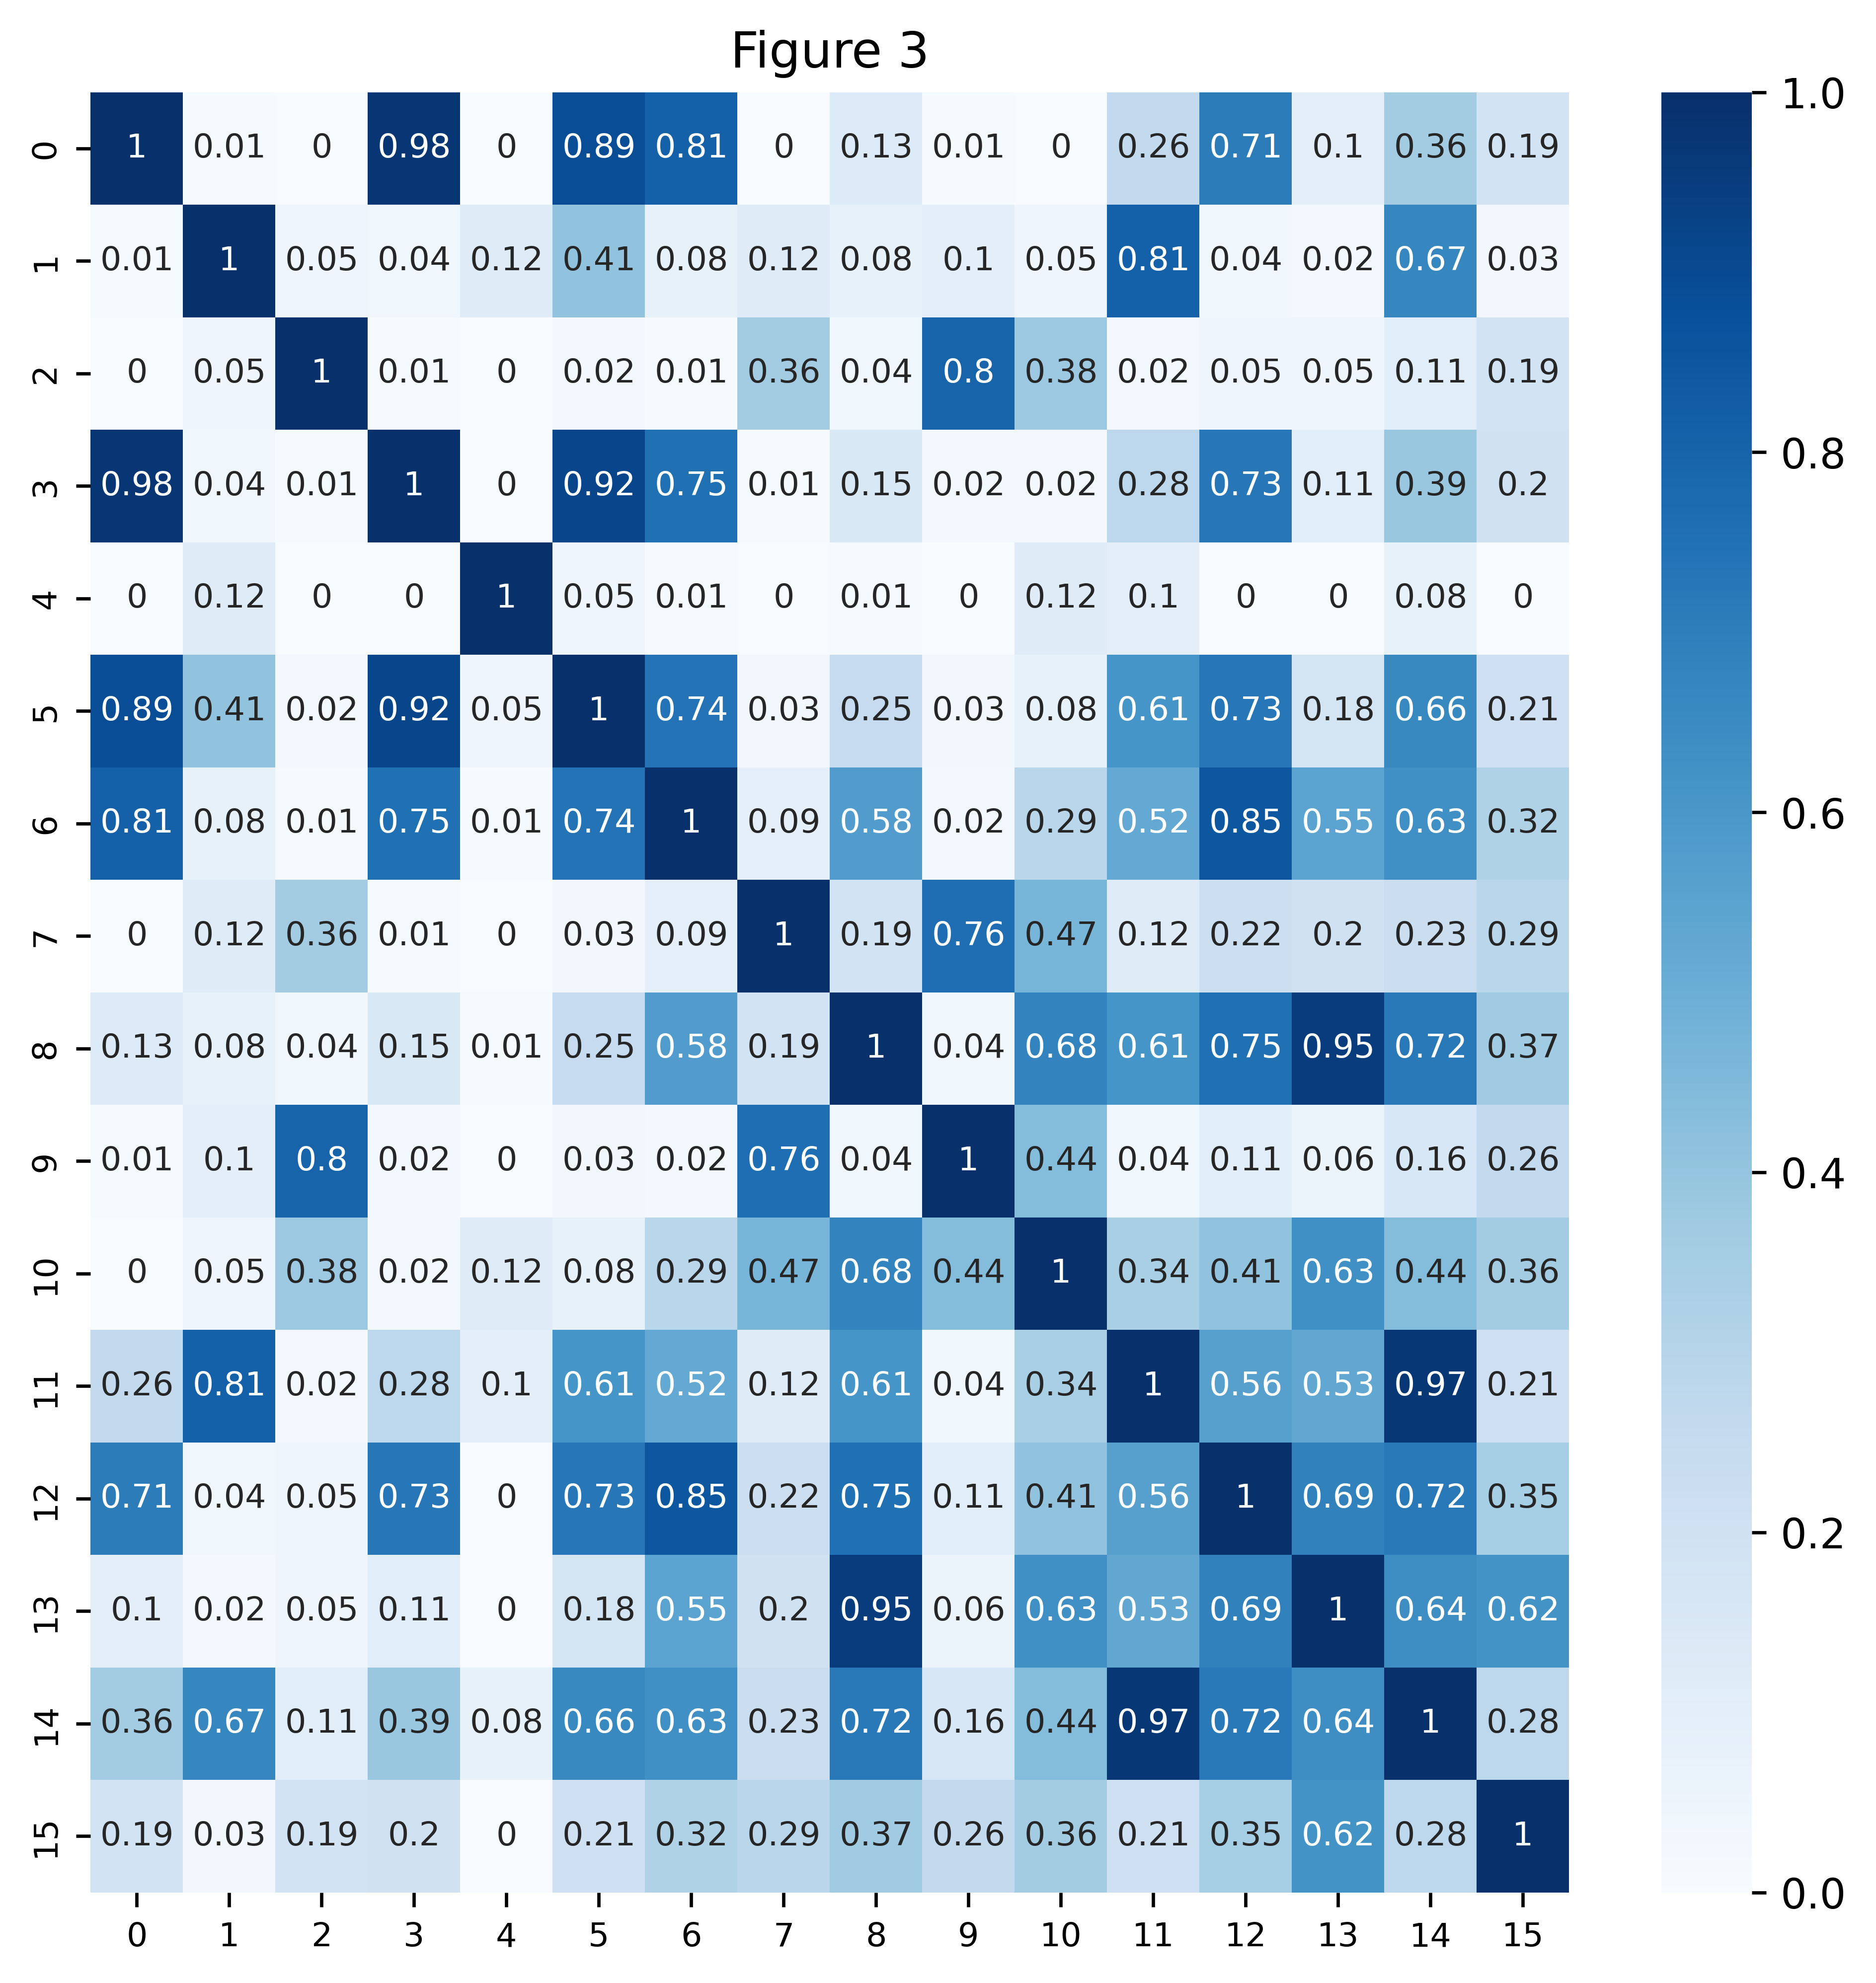

In [8]:
plot_matrix(matrix_cosine_similiarity, range(len(matrix_cosine_similiarity)), fig_size=(8, 8), label_size=8, title="Figure 3")

In **Figure 3** symmetrical matrix is shown which represents the cosine similarity of each cluster. Results indicate that clusters 0 and 3, 8 and 13, as well as 11 and 14, are very similar and could be grouped together. In order to group them threshold value for similarity is defined to be 0.85. It is decided empirically based on **Figure 3** but some optimization methods can be applied to search for the optimal value.

In [9]:
similiarity_dict = group_similiar_clusters(matrix_cosine_similiarity, similiarity=0.85)

Function *group_similiar_clusters* is used to create a dictionary by using a cosine similarity matrix to determine the most similar clusters and group them.
<br>
dict.keys() represent clusters and dict.values() are lists with indexes (which in this case represent corresponding clusters) of values greater than predefined parameter similarity.

In [10]:
similiarity_dict

{0: [3, 5], 8: [13], 11: [14]}

When the value of parameter similarity is 0.85, the following grouping is recommended:

$$ \text {Table 2} $$

| Group | New cluster annotation |
| :- | :-: |
| [0, 3, 5] | 0 |
| [8, 13]  | 8 |
| [11, 14] | 11 |

In [11]:
# Make new column where proposed clusters will be stored
df['proposed clusters'] = df['clusters']

In [12]:
# Group clusters based on cosine similiarity metric
for key, values in similiarity_dict.items():   
    for value in values:
        df['proposed clusters'] = df['proposed clusters'].replace(value, key)     

After grouping clusters together, they are numbered from 0 to *n*. Where *n* represents the new number of clusters

In [13]:
# Sort them from 0 to n - new number of clusters
proposed_clusters = df["proposed clusters"].unique()
proposed_clusters.sort()
for index, value in enumerate(proposed_clusters):
    df['proposed clusters'] = df['proposed clusters'].replace(value, index)

Next step is to again calculate matricies for comparison of proposed and ground truth clusters, and analyze the results.

In [14]:
matrix_proposed_clusters = make_matrix(df, comparison_type="clusters", cluster_column="proposed clusters")
matrix_proposed_clusters_dataframe = make_matrix(df, comparison_type="dataframe", cluster_column="proposed clusters")

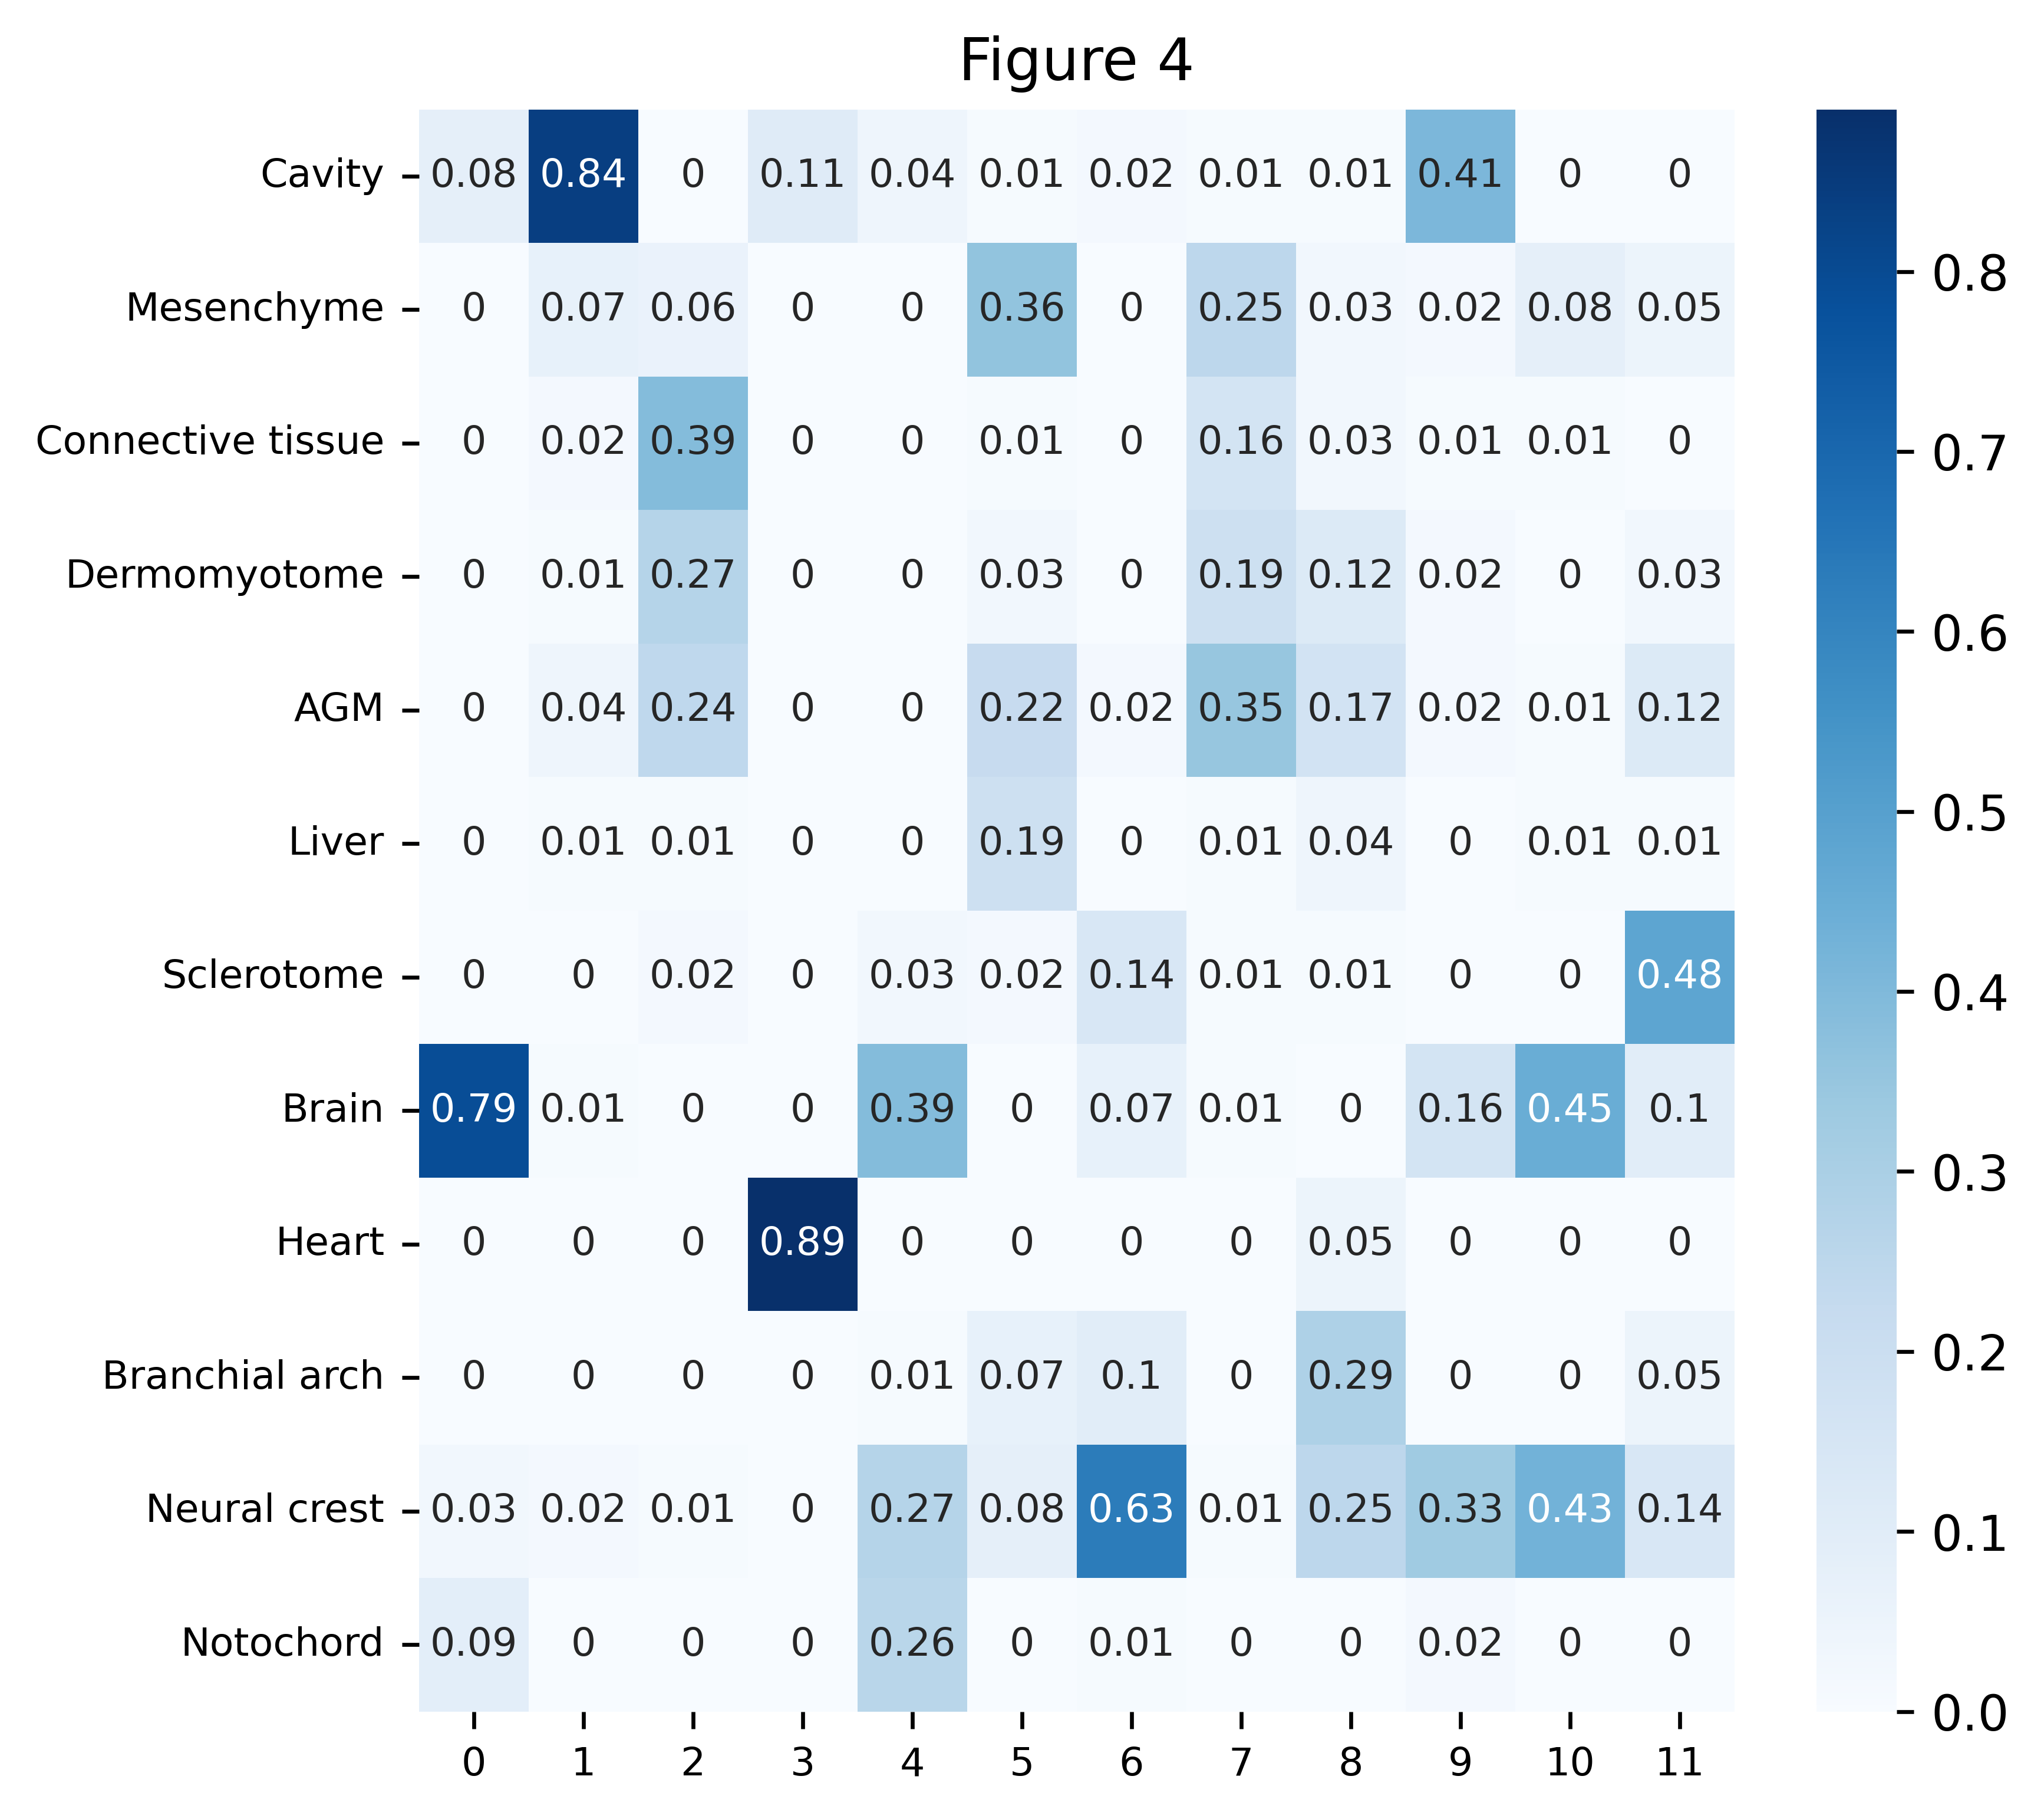

In [15]:
plot_matrix(matrix_proposed_clusters, labels_list, fig_size=(6, 6), label_size=8, title="Figure 4")

**Figure 4** shows similar results as in **Figure 1** and accurate mapping can not be performed because the mapping of the proposed clusters to the ground truth ones based on the highest percentage would leed to the loss of information and some clusters would not be represented with proposed clusters. In **Table 3** results of mapping based on **Figure 4** are shown.
<br>
**It should be noted that values in Figure 4 represent a percentage of each ground truth labels (*y* axis) within clusters (*x* axis).*
<br>

$$ \text {Table 3} $$

| Cluster | ground truth label |
| :- | :-: |
| 0 | **Brain** |
| 1  | **Cavity** |
| 2 | Connective tissue |
| 3 | Heart |
| 4  | **Brain** |
| 5 | Mesenchyme |
| 6 | Neural crest |
| 7  | AGM |
| 8 | Branchial arch |
| 9 | **Cavity** |
| 10  | **Brain** |
| 11 | Sclerotome |

Clusters 0, 4 and 10 would be mapped to the ground truth cluster *Brain* and clusters 1 and 9 would be mapped to the label *Cavity*. This would result in **9** unique clusters and ground truth clusters with labels *Dermomyotome*, *Liver*, *Notochord* would not be represented with any clusters. This would result in the loss of information and would lead to suboptimal clustering mapping.

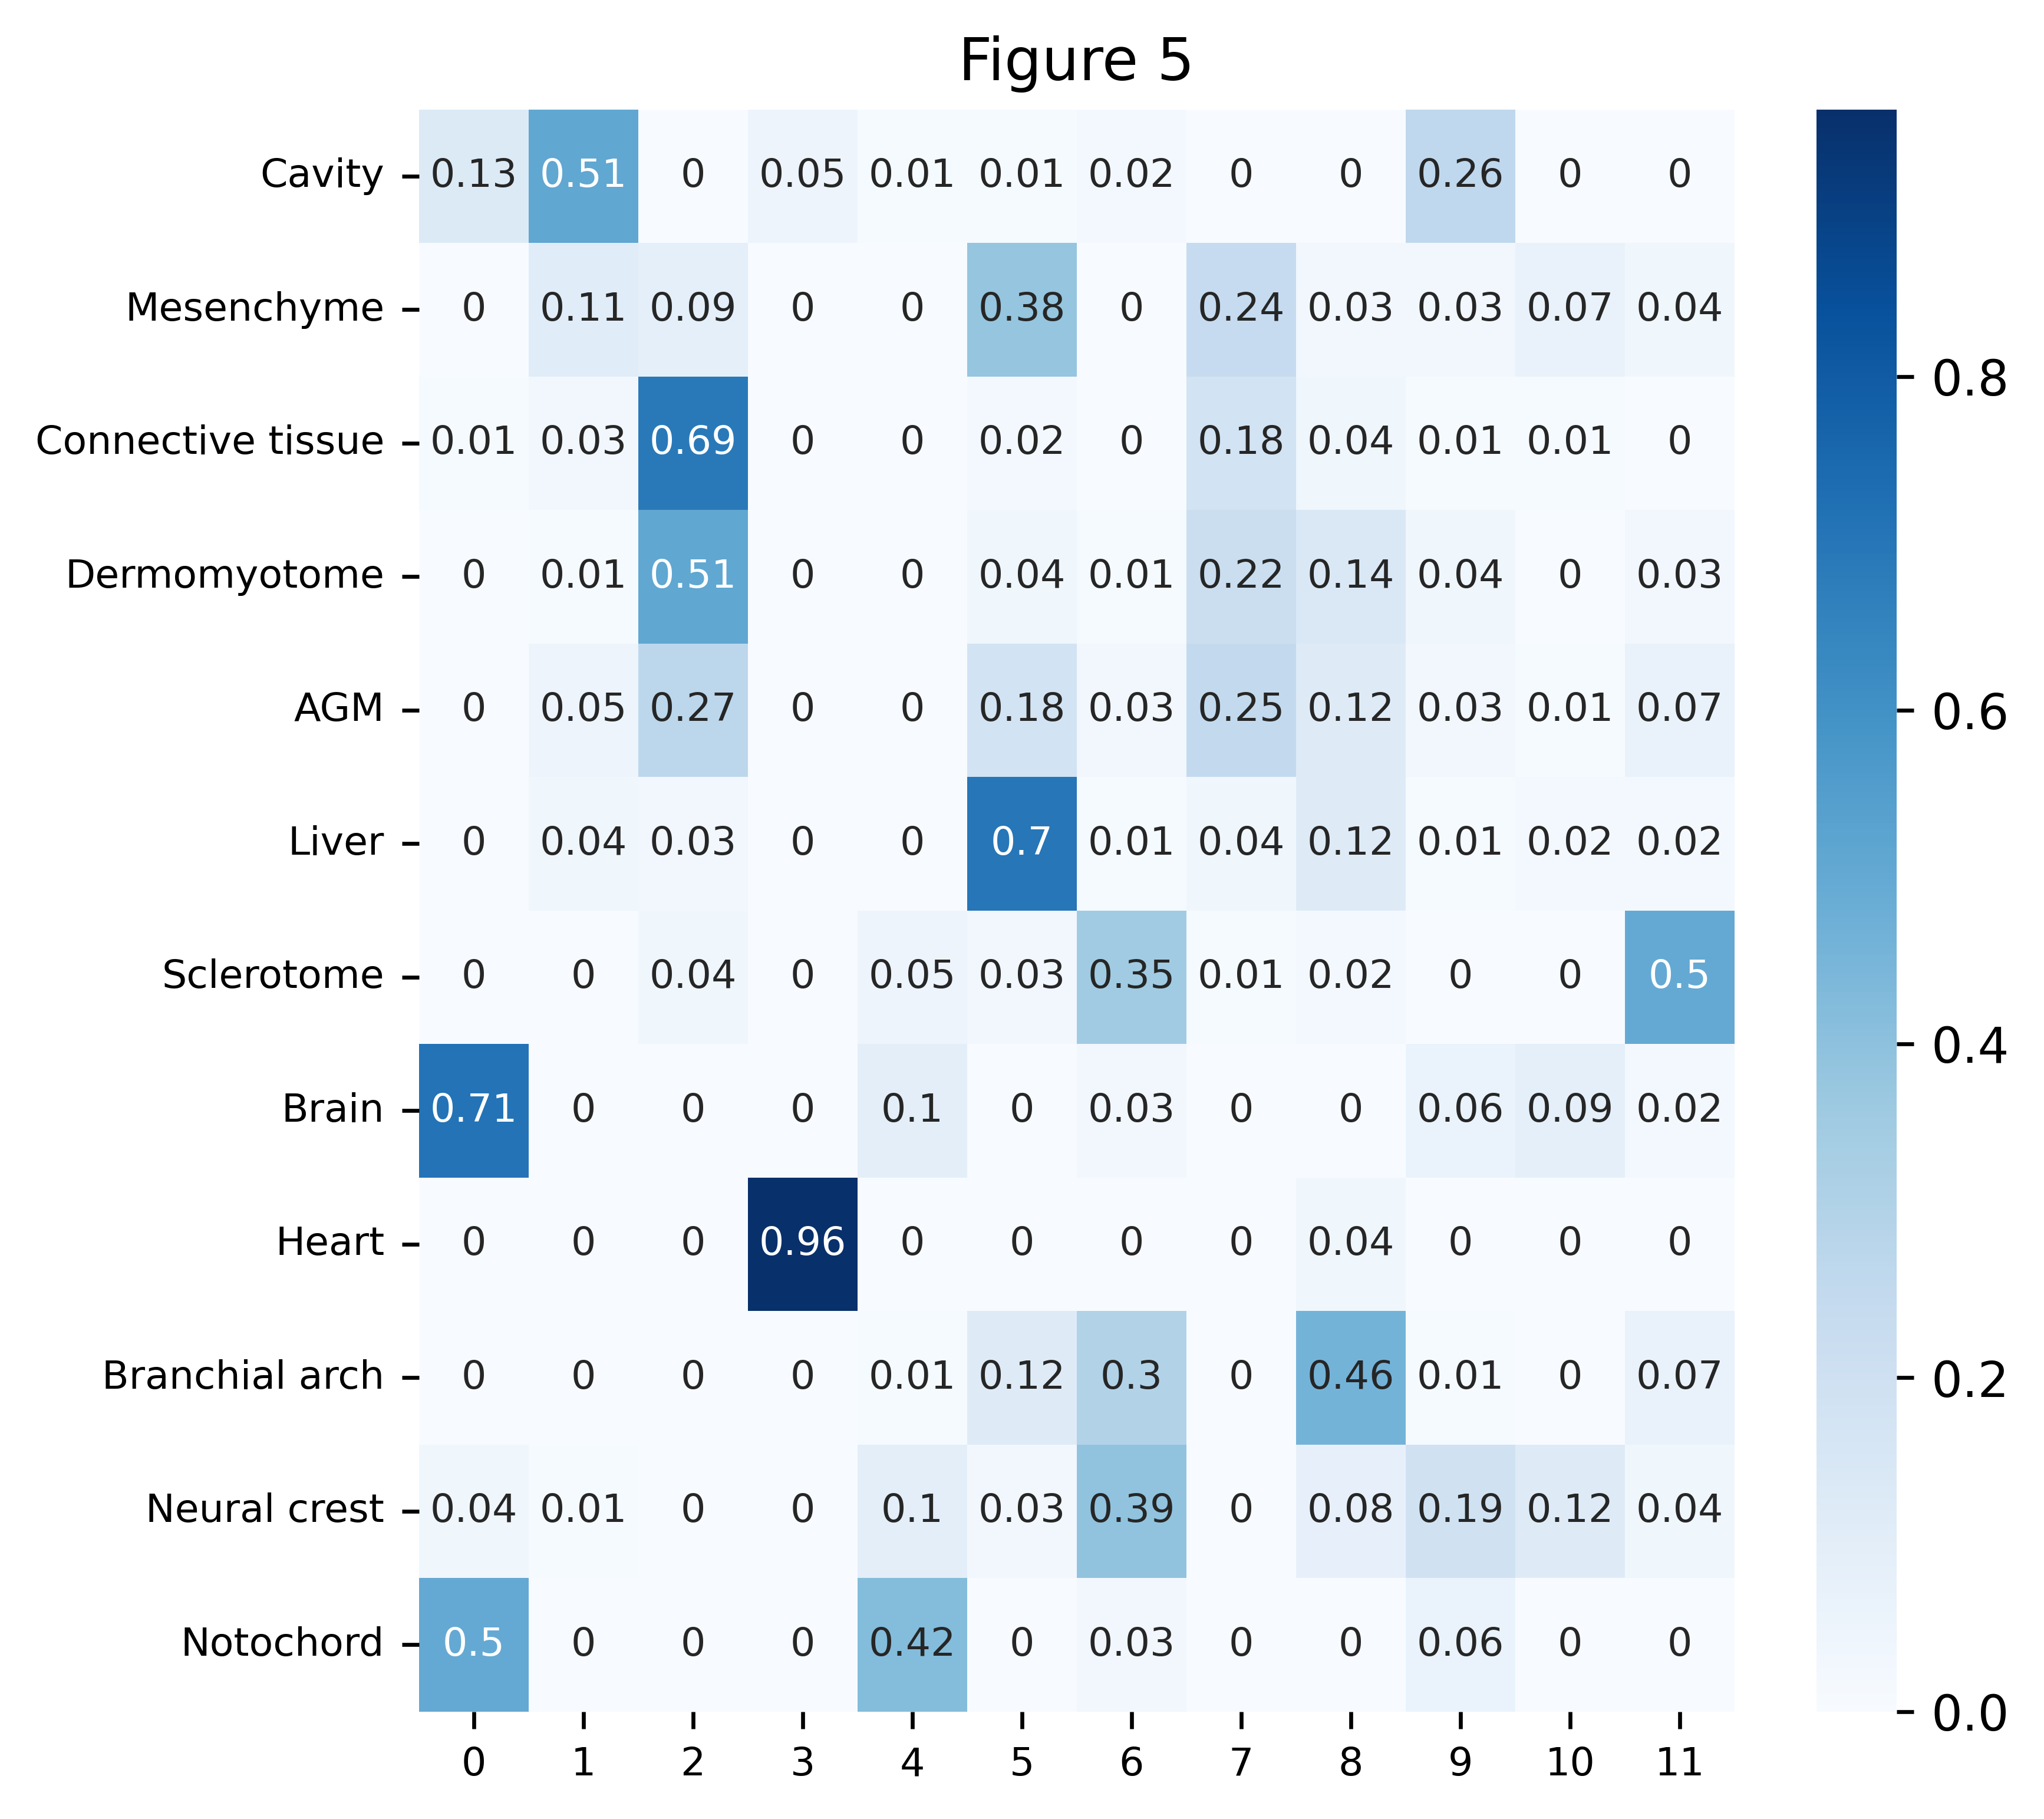

In [16]:
plot_matrix(matrix_proposed_clusters_dataframe, labels_list, fig_size=(6, 6), label_size=8, title="Figure 5")

**Figure 5** shows slightly better results for mapping of clusters and more accurate mapping can be performed than based on the results from **Figure 4**. As in the previous case, mapping of the proposed clusters to the ground truth ones will be based on the highest percentage. In **Table 4** results of mapping based on **Figure 5** are shown.
<br>
**It should be noted that values in Figure 5 represent what percentage of the total number of each ground truth labels (*y* axis) are contained within each proposed clusters (*x* axis).**
$$ \text {Table 4} $$

| Cluster | ground truth label |
| :- | :-: |
| 0 | Brain |
| 1  | **Cavity** |
| 2 | Connective tissue |
| 3 | Heart |
| 4  | Notochord |
| 5 | Liver |
| 6 | **Neural crest** |
| 7  | AGM |
| 8 | Branchial arch |
| 9 | **Cavity** |
| 10  | **Neural crest** |
| 11 | Sclerotome |

Clusters 1, and 9 would be mapped to the ground truth cluster *Cavity* and clusters 6 and 10 would be mapped to the label *Neural crest*. This would result in **10** unique clusters and ground truth clusters with labels *Mesenchyme* and *Dermomyotome* would not be represented with any clusters. This would also result in the loss of information and would lead to suboptimal clustering mapping, but one more cluster would be preserved than in the case when results from **Figure 4** are used.

To determine the best re-mapping of the proposed cluster to the ground truth clusters, two different approaches will be used.
The first approach (named *remapping 1*) is with 9 proposed clusters based on **Figure 4**, and the second approach (named *remapping 2*) is with 10 proposed clusters based on **Figure 5**.

In [17]:
# Creates new columns to store newly proposed clusters
df["remapping1"] = df["proposed clusters"]
df["remapping2"] = df["proposed clusters"]

# Remapping 1
mapping1 = remapping(matrix_proposed_clusters)
df["remapping1"] = df["remapping1"].replace(mapping1.keys(), mapping1.values())

# Remapping 2
mapping2 = remapping(matrix_proposed_clusters_dataframe)
df["remapping2"] = df["remapping2"].replace(mapping2.keys(), mapping2.values())

## Visualization of the proposed and ground-truth clustering in spatial coordinates

The first visualization is the comparison of ground truth clustering with initial clustering and proposed clustering after reducing clusters based on cosine similarity.

In [18]:
# First visualization
# New column is created in order to turn image upside down for visualization
df["y+"] = df["y"] * -1
# Another column is created in which strings from annotation column are converted to numerical values
df['ground truth'] = pd.factorize(df['annotation'])[0]

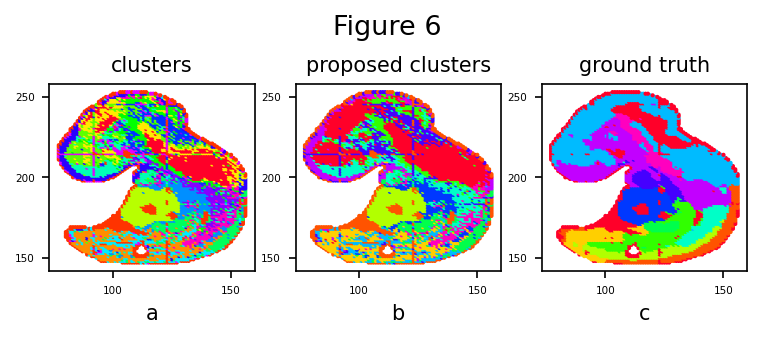

In [19]:
column_name = ["clusters", "proposed clusters", "ground truth"]
abc = ['a', 'b', 'c']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,2), dpi = 150)

fig.suptitle("Figure 6", fontsize=13)
plt.subplots_adjust(top=0.75)

for i, name in enumerate(column_name):
    axes[i].set_title(name, size=10)
    df.plot.scatter('x', 'y+', c=name, colormap='gist_rainbow', ax=axes[i], fontsize = 5, xlabel=abc[i], ylabel='', colorbar=False, s=1)


In **Figure 6** we can see initial clusters (a), proposed clusters (b), and ground truth clusters (c).
<br>
It can be seen that the proposed clusters are more similar to the ground truth clusters than the initial clusters.


The second visualization is the comparison of ground truth clustering with the first proposed remapping and the second proposed remapping.

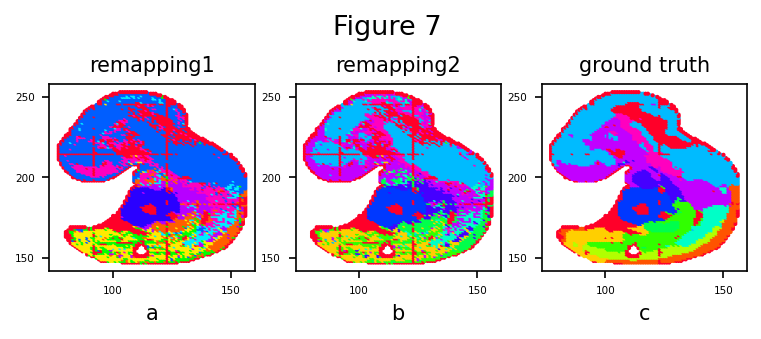

In [20]:
# Second visualization 

column_name = ["remapping1", "remapping2", "ground truth"]
abc = ['a', 'b', 'c']
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(6,2), dpi = 150)

fig.suptitle("Figure 7", fontsize=13)
plt.subplots_adjust(top=0.75)

for i, name in enumerate(column_name):
    axes[i].set_title(name, size=10)
    df.plot.scatter('x', 'y+', c=name, colormap='gist_rainbow', ax=axes[i], fontsize = 5, xlabel=abc[i], ylabel='', colorbar=False, s=1)


In **Figure 7** we can see the first remapping of proposed clusters (a) - 9 clusters are proposed, the second remapping of the proposed clusters (b) - 10 clusters are proposed, and ground truth clusters (c).
<br>
- First remapping is done based on results from **Figure 4** where values within the matrix represent a percentage of each ground truth labels within cluster.
- Second remapping is done based on results from **Figure 5** where values within the matrix represent what percentage of the total number of each ground truth labels are contained within each proposed cluster.


## Comparison of the proposed and ground-truth clustering using 3 existing metrics

Three existing metrics for comparison of proposed and ground truth clustering are:
1. Adjusted Rand Index (ARI)
2. Adjusted Mutual Information (AMI)
3. Fowlkes-Mallows Index (FMI)

### Comparison of initial and ground-truth clusters

In [21]:
ARI, AMI, FMI = evaluate_clustering(df, "clusters")

Adjusted Rand index is: 0.25
Adjusted Mutual Information is: 0.44
Fowlkes-Mallows Index is: 0.34


### Comparison of proposed clusters, after cosine similiarity grouping, and ground-truth clusters

In [22]:
ARI, AMI, FMI = evaluate_clustering(df, "proposed clusters")

Adjusted Rand index is: 0.39
Adjusted Mutual Information is: 0.46
Fowlkes-Mallows Index is: 0.46


### Comparison of proposed clusters after first remapping based on results from Figure 4 and ground-truth clusters

In [23]:
ARI, AMI, FMI = evaluate_clustering(df, "remapping1")

Adjusted Rand index is: 0.43
Adjusted Mutual Information is: 0.46
Fowlkes-Mallows Index is: 0.52


### Comparison of proposed clusters after second remapping based on results from Figure 5 and ground-truth clusters

In [24]:
ARI, AMI, FMI = evaluate_clustering(df, "remapping2")

Adjusted Rand index is: 0.4
Adjusted Mutual Information is: 0.46
Fowlkes-Mallows Index is: 0.48


In **Table 5** all comparison results are shown.

$$ \text {Table 5: Clustering comparison} $$

| Ground truth vs. | ARI | AMI | FMI |
| :- | :-: | :-: | :-: | 
| Initial clustering | 0.25 | 0.44 | 0.34 | 
| Proposed clustering | 0.39 | 0.46 | 0.46 | 
| **First remapping** | **0.43** | **0.46** | **0.52** | 
| Second remapping | 0.4 | 0.46 | 0.48 | 


## Implementation of a new metric that measures the similarity between proposed and ground-truth clustering

Novel metric that was implemented for clustering evaluation is **purity index**. This metric can be used only when ground truth labels are known and score ranges from 0 to 1. Higher value indicates better similiarity between proposed and ground truth clusters.
<br>
The mathematical formulation is as follows:
$$ \text{purity} = \sum \limits _{i=1} ^{n} (\frac{x_i}{\sum \limits _{i=1} ^{n} x_i})^2  $$
- $ x_i $ - represents sum of i-th label within cluster 
- $ \sum \limits _{i=1} ^{n} x_i $ - represents total number of elements\labels within cluster
- $ i = 1, 2, ..., n $ - where $ n $ is number of unique elements\labels within cluster

Purity is calculated for each cluster separately and each purity is multiplied with clusters corresponding purity weight.
Purity weight is calculated with mathematical expression:
$$ \text{purity weight} = \frac{\sum \limits _{i=1} ^{n} x_i}{\sum \limits _{j=1} ^{k} x_j} $$
- $ \sum \limits _{j=1} ^{k} x_j $ - represents sum of all elements\labels within all clusters
- $ j = 1, 2, ..., k $ - where $ k $ is number of clusters

Clustering purity is calculated by summing up all purities, in other words all purities of each cluster are added together.
$$ \text{clustering purity} = \sum \limits _{j=1} ^{k} purity_m $$
- $ j = 1, 2, ..., k $ - where $ k $ is number of clusters

When all elements\labels in cluster are the same, purity will be 1.

### Comparison of initial and ground-truth clusters

In [25]:
# Get corresponding labels for clusters
_, ground_truths = get_clusters_ground_truth(df, "ground truth", "clusters")
index = purity_index(ground_truths, len(df))
print("Purity index is: " + str(round(index, 2)))

Purity index is: 0.29


### Comparison of proposed clusters, after cosine similiarity grouping, and ground-truth clusters

In [26]:
# Get corresponding labels for clusters
_, ground_truths = get_clusters_ground_truth(df, "ground truth", "proposed clusters")
index = purity_index(ground_truths, len(df))
print("Purity index is: " + str(round(index, 2)))

Purity index is: 0.4


### Comparison of proposed clusters after first remapping based on results from Figure 4 and ground-truth clusters

In [31]:
# Get corresponding labels for clusters
_, ground_truths = get_clusters_ground_truth(df, "ground truth", "remapping1")
index = purity_index(ground_truths, len(df))
print("Purity index is: " + str(round(index, 2)))

Purity index is: 0.54


### Comparison of proposed clusters after second remapping based on results from Figure 5 and ground-truth clusters

In [28]:
# Get corresponding labels for clusters
_, ground_truths = get_clusters_ground_truth(df, "ground truth", "remapping2")
index = purity_index(ground_truths, len(df))
print("Purity index is: " + str(round(index, 2)))

Purity index is: 0.46


In **Table 6** all comparison results for purity metric are shown.

$$ \text {Table 6: Evaluation of clustering based on purity metric} $$

| Ground truth vs. | Purity Index |
| :- | :-: | 
| Initial clustering | 0.29 |
| Proposed clustering | 0.4 |
| **First remapping** | **0.54** |
| Second remapping | 0.46 |

Based on all results so far, the first remapping yields the best scores in all evaluation metrics.